In [28]:
from cProfile import label

import pandas as pd
from tensorflow.python.ops.losses.losses_impl import mean_squared_error
from tensorflow.python.ops.numpy_ops.np_dtypes import object_

df = pd.read_csv("Data/aggregated_spice_price_data_2019_2024.csv")
df

,Price Date,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
0,2019-10-31,8476.100000,9156.250000,8854.900000
1,2019-11-01,8362.619048,10080.666667,9385.238095
2,2019-11-02,8228.023256,9744.162791,9147.720930
3,2019-11-03,8620.000000,8881.111111,8768.888889
4,2019-11-04,8185.625000,9976.950000,9199.375000
...,...,...,...,...
1822,2024-10-26,9873.513514,11910.000000,11096.297297
1823,2024-10-27,10366.666667,10916.666667,10635.166667
1824,2024-10-28,10333.593750,11987.500000,11361.281250
1825,2024-10-29,9893.684211,11420.263158,10820.263158


In [29]:
df = df[["Price Date", "Modal Price (Rs./Quintal)"]]
# Convert 'Price Date' to datetime format using .loc to avoid the SettingWithCopyWarning
df.loc[:, 'Price Date'] = pd.to_datetime(df['Price Date'])

# Set 'Price Date' as the index
df.set_index('Price Date', inplace=True)

# Get the datatype of the index
index_dtype = df.index.dtype
print(f"Datatype of the index: {index_dtype}")



Datatype of the index: datetime64[ns]


/Users/tejas/PycharmProjects/Spice_Price_Forecast/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [30]:
df

,Modal Price (Rs./Quintal)
Price Date,
2019-10-31,8854.900000
2019-11-01,9385.238095
2019-11-02,9147.720930
2019-11-03,8768.888889
2019-11-04,9199.375000
...,...
2024-10-26,11096.297297
2024-10-27,10635.166667
2024-10-28,11361.281250


In [31]:
import seaborn as sns
color_pal = sns.color_palette()

<Axes: title={'center': 'Modal Price'}, xlabel='Price Date'>

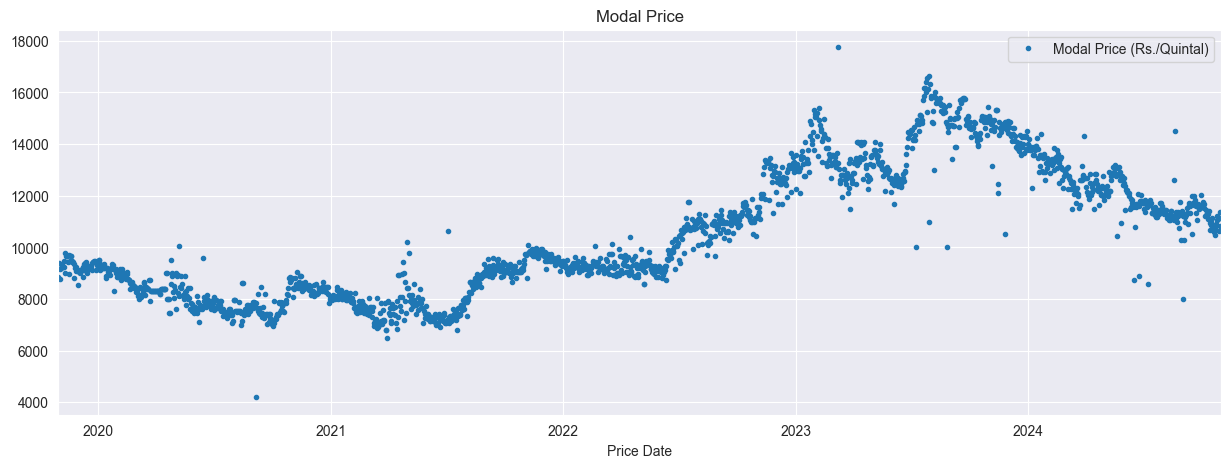

In [32]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title="Modal Price", )

In [33]:
train_df = df.iloc[df.index<'08-31-2024']
test_df = df.iloc[df.index>='08-31-2024']

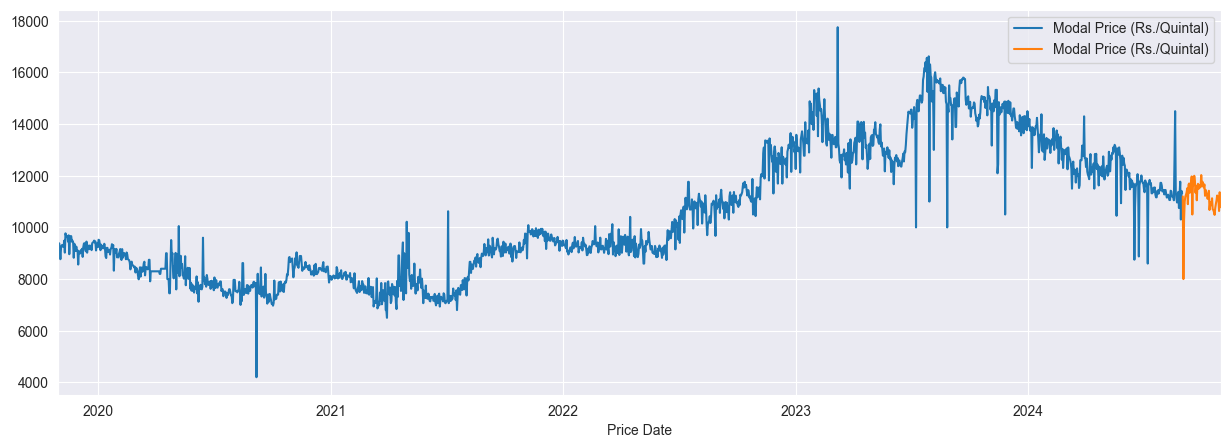

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training set')
test_df.plot(ax=ax, label='Test set')
plt.show()

<Axes: xlabel='Price Date'>

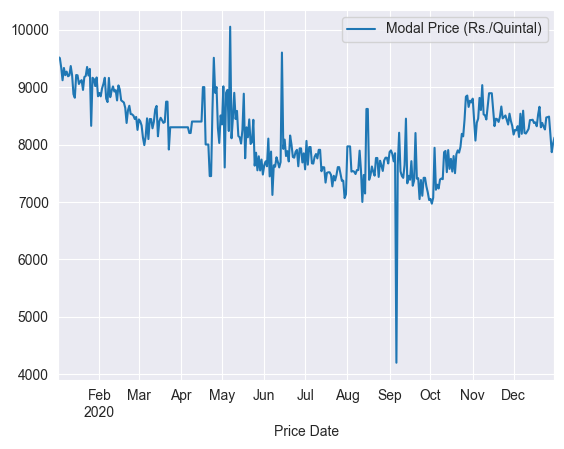

In [35]:
df.iloc[(df.index>'01-01-2020') & (df.index<'01-01-2021')].plot()

In [36]:
target_map = df['Modal Price (Rs./Quintal)'].to_dict()

In [37]:
def create_features(df):
    """
    Create time series features based on time series index, with a focus on quarterly, semi-annual, and annual aggregations.
    """
    df = df.copy()

    # Time-based features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear

    # Lag features using a target map (assuming 'target_map' is defined elsewhere)
    df['lag1'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('180 days')).map(target_map)

    # Quarterly rolling statistics (90-day window)
    df['rolling_mean_quarter'] = df['Modal Price (Rs./Quintal)'].rolling(window=90).mean()
    df['rolling_median_quarter'] = df['Modal Price (Rs./Quintal)'].rolling(window=90).median()
    df['ema_quarter'] = df['Modal Price (Rs./Quintal)'].ewm(span=90, adjust=False).mean()
    df['rolling_std_quarter'] = df['Modal Price (Rs./Quintal)'].rolling(window=90).std()
    df['rolling_min_quarter'] = df['Modal Price (Rs./Quintal)'].rolling(window=90).min()
    df['rolling_max_quarter'] = df['Modal Price (Rs./Quintal)'].rolling(window=90).max()

    # Semi-annual rolling statistics (180-day window)
    df['rolling_mean_6m'] = df['Modal Price (Rs./Quintal)'].rolling(window=180).mean()
    df['rolling_median_6m'] = df['Modal Price (Rs./Quintal)'].rolling(window=180).median()
    df['ema_6m'] = df['Modal Price (Rs./Quintal)'].ewm(span=180, adjust=False).mean()
    df['rolling_std_6m'] = df['Modal Price (Rs./Quintal)'].rolling(window=180).std()
    df['rolling_min_6m'] = df['Modal Price (Rs./Quintal)'].rolling(window=180).min()
    df['rolling_max_6m'] = df['Modal Price (Rs./Quintal)'].rolling(window=180).max()

    # Annual rolling statistics (365-day window)
    df['rolling_mean_1yr'] = df['Modal Price (Rs./Quintal)'].rolling(window=365).mean()
    df['rolling_median_1yr'] = df['Modal Price (Rs./Quintal)'].rolling(window=365).median()
    df['ema_1yr'] = df['Modal Price (Rs./Quintal)'].ewm(span=365, adjust=False).mean()
    df['rolling_std_1yr'] = df['Modal Price (Rs./Quintal)'].rolling(window=365).std()
    df['rolling_min_1yr'] = df['Modal Price (Rs./Quintal)'].rolling(window=365).min()
    df['rolling_max_1yr'] = df['Modal Price (Rs./Quintal)'].rolling(window=365).max()

    # Cumulative mean up to each point in time
    df['cumulative_mean'] = df['Modal Price (Rs./Quintal)'].expanding().mean()

    return df


In [38]:
df = create_features(df)

In [39]:
df

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,lag1,lag2,rolling_mean_quarter,rolling_median_quarter,...,rolling_std_6m,rolling_min_6m,rolling_max_6m,rolling_mean_1yr,rolling_median_1yr,ema_1yr,rolling_std_1yr,rolling_min_1yr,rolling_max_1yr,cumulative_mean
Price Date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,8854.900000,3,4,10,2019,304,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8854.900000,NaN,NaN,NaN,8854.900000
2019-11-01,9385.238095,4,4,11,2019,305,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8857.798022,NaN,NaN,NaN,9120.069048
2019-11-02,9147.720930,5,4,11,2019,306,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8859.382301,NaN,NaN,NaN,9129.286342
2019-11-03,8768.888889,6,4,11,2019,307,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8858.887801,NaN,NaN,NaN,9039.186979
2019-11-04,9199.375000,0,4,11,2019,308,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8860.748387,NaN,NaN,NaN,9071.224583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-26,11096.297297,5,4,10,2024,300,11725.500000,12300.272727,11290.763765,11279.369048,...,783.191062,8000.0,14500.0,12493.037401,12273.166667,12157.393712,1274.536724,8000.0,15436.090909,10504.296574
2024-10-27,10635.166667,6,4,10,2024,301,11622.321429,11854.523810,11279.795379,11277.647783,...,786.031625,8000.0,14500.0,12481.477802,12270.105263,12149.075532,1272.192393,8000.0,15436.090909,10504.368323
2024-10-28,11361.281250,0,4,10,2024,302,11389.678571,12038.842105,11279.479853,11277.647783,...,785.389387,8000.0,14500.0,12473.323778,12260.416667,12144.770645,1269.799351,8000.0,15436.090909,10504.837864


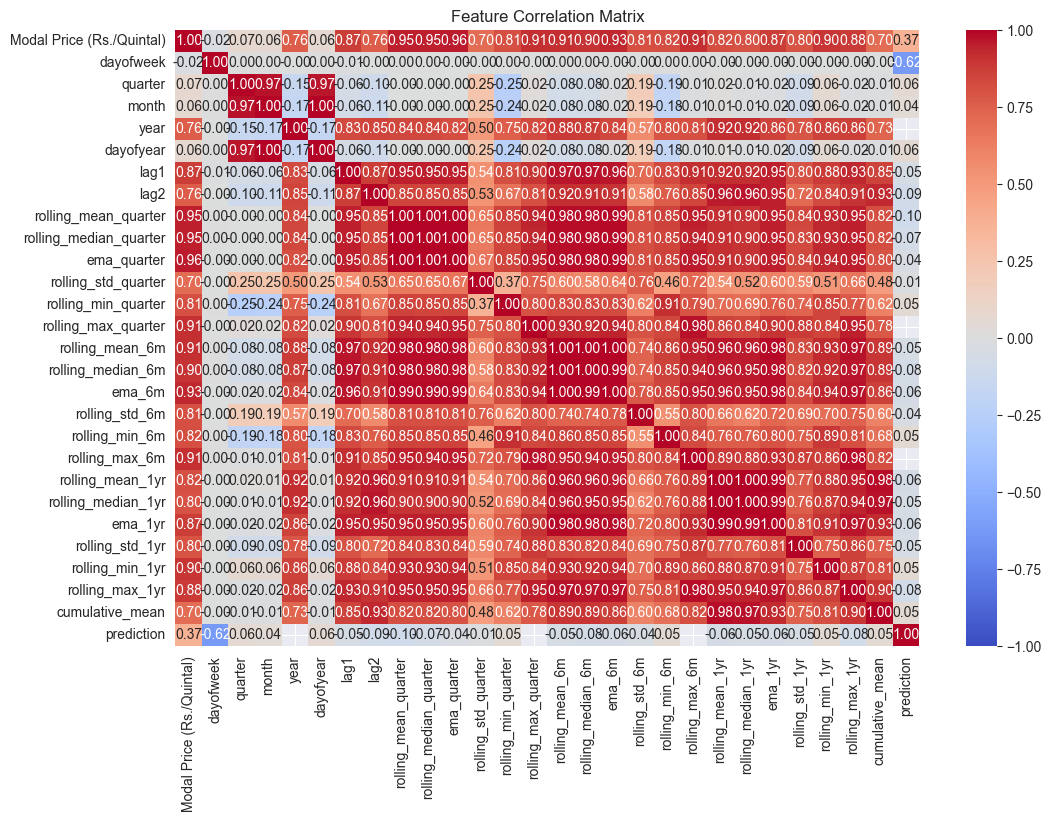

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


In [40]:
train_df = df.iloc[df.index<'08-31-2024']
test_df = df.iloc[df.index>='08-31-2024']

In [41]:
df.columns

Index(['Modal Price (Rs./Quintal)', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'lag1', 'lag2', 'rolling_mean_quarter',
       'rolling_median_quarter', 'ema_quarter', 'rolling_std_quarter',
       'rolling_min_quarter', 'rolling_max_quarter', 'rolling_mean_6m',
       'rolling_median_6m', 'ema_6m', 'rolling_std_6m', 'rolling_min_6m',
       'rolling_max_6m', 'rolling_mean_1yr', 'rolling_median_1yr', 'ema_1yr',
       'rolling_std_1yr', 'rolling_min_1yr', 'rolling_max_1yr',
       'cumulative_mean'],
      dtype='object')

In [42]:
FEATURES = ['dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'lag1', 'lag2', 'rolling_mean_quarter',
            'rolling_median_quarter', 'ema_quarter', 'rolling_std_quarter',
            'rolling_min_quarter', 'rolling_max_quarter', 'rolling_mean_6m',
            'rolling_median_6m', 'ema_6m', 'rolling_std_6m', 'rolling_min_6m',
            'rolling_max_6m', 'rolling_mean_1yr', 'rolling_median_1yr', 'ema_1yr',
            'rolling_std_1yr', 'rolling_min_1yr', 'rolling_max_1yr',
            'cumulative_mean']
TARGET = 'Modal Price (Rs./Quintal)'

In [43]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [44]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the model
xgb_model = xgb.XGBRegressor(early_stopping_rounds=50)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

# Retrieve the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best parameters found: {best_params}")
print(f"Best model: {best_model}")

# You can also make predictions using the best model
y_pred = best_model.predict(X_test)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-rmse:734.52383
[0]	validation_0-rmse:2203.34902
[0]	validation_0-rmse:720.01456
[0]	validation_0-rmse:719.83171
[0]	validation_0-rmse:2203.57224
[0]	validation_0-rmse:734.25096
[0]	validation_0-rmse:734.05149
[0]	validation_0-rmse:719.83860
[85]	validation_0-rmse:784.89800
[52]	validation_0-rmse:747.13295
[100]	validation_0-rmse:674.39880
[100]	validation_0-rmse:588.19974
[100]	validation_0-rmse:679.85595
[100]	validation_0-rmse:754.97573
[100]	validation_0-rmse:669.82896
[113]	validation_0-rmse:764.84909
[134]	validation_0-rmse:791.73076
[100]	validation_0-rmse:590.06193
[0]	validation_0-rmse:720.01456
[200]	validation_0-rmse:626.05717
[0]	validation_0-rmse:2203.43661
[133]	validation_0-rmse:818.53951
[200]	validation_0-rmse:640.91481
[200]	validation_0-rmse:630.98374
[0]	validation_0-rmse:734.25096
[300]	validation_0-rmse:597.35699
[100]	validation_0-rmse:674.39880
[0]	validation_0-rmse:2203.34902
[300]	v

In [45]:
fi = pd.DataFrame(data=best_model.feature_importances_,
                  index=best_model.feature_names_in_,
                  columns=['Importance'])

In [46]:
fi

,Importance
dayofweek,0.002326
quarter,0.046287
month,0.002101
year,0.048591
dayofyear,0.003972
lag1,0.001423
lag2,0.001187
rolling_mean_quarter,0.192186
rolling_median_quarter,0.030227
ema_quarter,0.197333


In [47]:
test_df["prediction"] = y_pred

/var/folders/nh/b1_7lrqd3230f7mwnl4b2r3c0000gn/T/ipykernel_58931/251849141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["prediction"] = y_pred


In [48]:
df = df.merge(test_df[['prediction']], how='left', left_index=True, right_index=True)

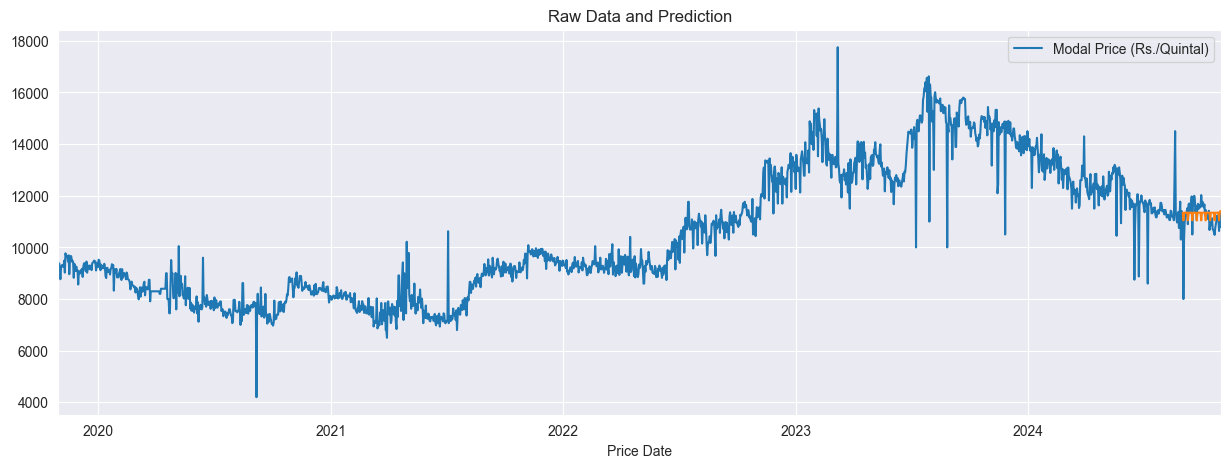

In [49]:
ax = df[[TARGET]].plot(figsize=(15, 5))
df['prediction'].plot(ax = ax)
ax.set_title('Raw Data and Prediction')
plt.show()